In [1]:
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

C:\Users\otag\AppData\Local\Continuum\anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Preparation

In [2]:
campaigns = pd.read_csv('campaigns.csv', index_col=0)
campaigns['campaign_start'] = pd.to_datetime(campaigns['campaign_start'])
campaigns['campaign_end'] = pd.to_datetime(campaigns['campaign_end'])
campaigns['roas'] = pd.to_numeric(campaigns['roas'])
campaigns['startmonth'] = campaigns.campaign_start.dt.month
campaigns['endmonth'] = campaigns.campaign_end.dt.month
campaigns['campaignlength'] = (campaigns.campaign_end - campaigns.campaign_start)
campaigns['campaignlength'] = campaigns.campaignlength.dt.days
campaigns = campaigns[(campaigns.campaignlength >= 1 )]
campaigns['dailyspend'] = (campaigns.spend / campaigns.campaignlength)
campaigns.rating.fillna(campaigns.rating.median(), inplace=True)
campaigns.reviews.fillna(campaigns.reviews.median(), inplace=True)
campaigns.price.fillna(campaigns.price.median(), inplace=True)
campaigns = campaigns.dropna(axis=0, how='any')
campaigns = campaigns.drop(['campaign_start','campaign_end'], axis=1)

In [3]:
advertiser_dummies = pd.get_dummies(campaigns.advertiser_name, prefix='advertiser')
cat_dummies = pd.get_dummies(campaigns.category, prefix='category')
completecampaigns = pd.concat([campaigns, cat_dummies], axis=1)
completecampaigns = pd.concat([completecampaigns, advertiser_dummies], axis=1)

In [4]:
X = completecampaigns.drop(['advertiser_name','ad_campaign_id','spend','sales','roas','category'], axis=1)
y = completecampaigns.roas

## Model

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [6]:
# create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# fill the array with the mean value of y_test
y_null.fill(y_test.mean())

# compute null RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_null))

6.8515231293927723

In [7]:
# null MAE
np.sqrt(metrics.mean_absolute_error(y_test, y_null))

1.8772478301042337

In [8]:
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state = 1)
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

4.8814046887107745

In [9]:
metrics.mean_absolute_error(y_test, y_pred)

2.0146409387208926

In [10]:
bagreg.fit(X_train, y_train)
bagreg.oob_score_

0.35776757361262834

In [13]:
bagreg.fit(X, y)
bagreg.oob_score_

0.48501713488222598

In [11]:
bagreg.fit(X, y)
scores = cross_val_score(bagreg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

7.9116442041851247

In [11]:
X.shape

(3414, 993)

In [ ]:
#predictions = pd.DataFrame({'predictions':y_pred, 'actual':y_test})
#predictions.to_csv('predictions.csv')

(8.9778539560095894, 40)

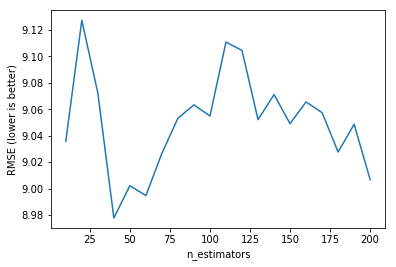

In [9]:
# list of values to try for n_estimators
estimator_range = range(10, 210, 10)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range_dum:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
    
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

# show the best RMSE and the corresponding n_estimator
sorted(zip(RMSE_scores, estimator_range))[0]

In [ ]:
# list of values to try for max_features
feature_range = range(1, 993)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=40, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
    
# plot max_features (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')

# show the best RMSE and the corresponding max_features
sorted(zip(RMSE_scores, feature_range))[0]

In [ ]:
# important features
# n_estimators = 40 and max_features = 1
rfreg = RandomForestRegressor(n_estimators=10, max_features=1, oob_score=True)
rfreg.fit(X_dummies, y_dummies)

pd.DataFrame({'feature':X_dummies.columns, 'importance':rfreg.feature_importances_}).sort_values('importance', ascending=False).head(20)